In [1]:
%matplotlib inline
import math
from math import pi

import numpy as np
import pandas as pd
import collections

import scipy.stats as stats
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sn

from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.metrics import calinski_harabasz_score, davies_bouldin_score 
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster, cophenet
from scipy.stats import mode
from scipy.spatial.distance import pdist


In [2]:
df = pd.read_csv("dataset/tennis_players.csv", skipinitialspace=True, sep=',')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2072 entries, 0 to 2071
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Unnamed: 0             2072 non-null   int64  
 1   name                   2072 non-null   object 
 2   ratio                  2072 non-null   float64
 3   num_matches_2016-2019  2072 non-null   float64
 4   ratio_2016-2019        2072 non-null   float64
 5   num_matches_2020-2021  2072 non-null   float64
 6   ratio_2020-2021        2072 non-null   float64
 7   hand                   2072 non-null   object 
 8   gender                 2072 non-null   object 
 9   ioc                    2072 non-null   object 
 10  birth                  2072 non-null   float64
 11  ht                     2072 non-null   float64
 12  minutes                2072 non-null   float64
 13  perc_ace               2072 non-null   float64
 14  serv_won_tot_seve      2072 non-null   float64
 15  bpFa

In [3]:
del df['Unnamed: 0']

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2072 entries, 0 to 2071
Data columns (total 20 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   name                   2072 non-null   object 
 1   ratio                  2072 non-null   float64
 2   num_matches_2016-2019  2072 non-null   float64
 3   ratio_2016-2019        2072 non-null   float64
 4   num_matches_2020-2021  2072 non-null   float64
 5   ratio_2020-2021        2072 non-null   float64
 6   hand                   2072 non-null   object 
 7   gender                 2072 non-null   object 
 8   ioc                    2072 non-null   object 
 9   birth                  2072 non-null   float64
 10  ht                     2072 non-null   float64
 11  minutes                2072 non-null   float64
 12  perc_ace               2072 non-null   float64
 13  serv_won_tot_seve      2072 non-null   float64
 14  bpFaced                2072 non-null   float64
 15  perc

## drop categorical data

In [5]:
del df['name']
del df['hand']
del df['gender']
del df['ioc']

In [6]:
df.head()

,ratio,num_matches_2016-2019,ratio_2016-2019,num_matches_2020-2021,ratio_2020-2021,birth,ht,minutes,perc_ace,serv_won_tot_seve,bpFaced,perc_df,perc_2ndwon,perc_v_ace,perc_v_df,perc_v_1stwon
0,0.181818,10.0,0.200000,1.0,0.000000,1996.0,187.076923,86.694444,14.98,0.587855,83.0,12.32,47.78,8.82,5.88,75.79
1,0.477707,142.0,0.478873,15.0,0.466667,1994.0,170.857143,61.621951,1.30,0.279256,819.0,4.67,22.10,3.18,5.39,39.67
2,0.500000,13.0,0.461538,3.0,0.666667,1998.0,183.800000,86.875000,20.59,0.613701,111.0,10.89,51.65,7.12,10.10,70.86
3,0.588710,111.0,0.576577,13.0,0.692308,1992.0,172.137193,62.577626,3.37,0.591260,1055.0,11.18,54.40,3.83,7.73,52.62
4,0.153846,13.0,0.153846,0.0,0.000000,1995.0,172.137193,59.409091,0.00,0.189542,110.0,16.30,17.20,0.51,2.55,11.88


## drop most correlated attributes

In [7]:
corr_threshold = 0.9
print("Att. A\tAtt. B\tCorr(A,B)")
for i in range(0, len(df.columns)):
    for j in range(i+1, len(df.columns)):
        corr = df[df.columns[i]].corr(df[df.columns[j]])
        if  corr > corr_threshold:
            print(df.columns[i] + "\t" + df.columns[j] + "\t" + '{:.4f}'.format(corr))

Att. A	Att. B	Corr(A,B)
num_matches_2016-2019	bpFaced	0.9253
serv_won_tot_seve	perc_2ndwon	0.9248


In [8]:
del df['num_matches_2016-2019']
del df['bpFaced']
del df['serv_won_tot_seve']
del df['perc_2ndwon']

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2072 entries, 0 to 2071
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   ratio                  2072 non-null   float64
 1   ratio_2016-2019        2072 non-null   float64
 2   num_matches_2020-2021  2072 non-null   float64
 3   ratio_2020-2021        2072 non-null   float64
 4   birth                  2072 non-null   float64
 5   ht                     2072 non-null   float64
 6   minutes                2072 non-null   float64
 7   perc_ace               2072 non-null   float64
 8   perc_df                2072 non-null   float64
 9   perc_v_ace             2072 non-null   float64
 10  perc_v_df              2072 non-null   float64
 11  perc_v_1stwon          2072 non-null   float64
dtypes: float64(12)
memory usage: 194.4 KB


## Normalization by Min-max

A good practice in clustering to avoid the bias given by the range of the different attribute is normalization.
The most common adopted normalizations are: Z-Score and Min-Max

### Min-Max

In [10]:
minmax = MinMaxScaler()
df_norm_minmax = minmax.fit_transform(df.values)
print(df_norm_minmax)

[[0.06811316 0.2        0.00990099 ... 0.37650602 0.32867524 0.93740611]
 [0.48378779 0.47887324 0.14851485 ... 0.133821   0.30128563 0.48522784]
 [0.51510574 0.46153846 0.02970297 ... 0.30335628 0.56456121 0.87568853]
 ...
 [0.44116712 0.38596491 0.18811881 ... 0.07917384 0.22079374 0.34088633]
 [0.57580844 0.53846154 0.02970297 ... 0.36660929 0.41475685 0.82511267]
 [0.54257456 0.54658385 0.17821782 ... 0.09380379 0.28731135 0.44416625]]


### Z-Score Normalization

In [11]:
zscore = StandardScaler()
zscore.fit(df.values)

StandardScaler()

In [12]:
df.head().values

array([[1.81818182e-01, 2.00000000e-01, 1.00000000e+00, 0.00000000e+00,
        1.99600000e+03, 1.87076923e+02, 8.66944444e+01, 1.49800000e+01,
        1.23200000e+01, 8.82000000e+00, 5.88000000e+00, 7.57900000e+01],
       [4.77707006e-01, 4.78873239e-01, 1.50000000e+01, 4.66666667e-01,
        1.99400000e+03, 1.70857143e+02, 6.16219512e+01, 1.30000000e+00,
        4.67000000e+00, 3.18000000e+00, 5.39000000e+00, 3.96700000e+01],
       [5.00000000e-01, 4.61538462e-01, 3.00000000e+00, 6.66666667e-01,
        1.99800000e+03, 1.83800000e+02, 8.68750000e+01, 2.05900000e+01,
        1.08900000e+01, 7.12000000e+00, 1.01000000e+01, 7.08600000e+01],
       [5.88709677e-01, 5.76576577e-01, 1.30000000e+01, 6.92307692e-01,
        1.99200000e+03, 1.72137193e+02, 6.25776256e+01, 3.37000000e+00,
        1.11800000e+01, 3.83000000e+00, 7.73000000e+00, 5.26200000e+01],
       [1.53846154e-01, 1.53846154e-01, 0.00000000e+00, 0.00000000e+00,
        1.99500000e+03, 1.72137193e+02, 5.94090909e+01, 0.00

In [13]:
zscore.transform(df.head().values)

array([[-2.64930487, -2.06390094, -0.85796791, -1.17035584,  0.4335402 ,
         0.99563378,  0.38846746,  1.55223474,  1.41410541,  0.46294132,
        -0.2423825 ,  1.11611858],
       [-0.07737614,  0.00527449, -0.3251156 ,  0.59196717,  0.03842461,
        -1.03008211, -1.16701822, -1.01746906, -0.80746618, -0.76782793,
        -0.49215778, -0.76108317],
       [ 0.11639931, -0.12334558, -0.78184615,  1.34724847,  0.82865579,
         0.58637329,  0.39966904,  2.6060387 ,  0.99883125,  0.09196477,
         1.90874341,  0.85990029],
       [ 0.88748274,  0.73021083, -0.40123736,  1.4440794 , -0.35669098,
        -0.87021448, -1.10772863, -0.6286323 ,  1.08304769, -0.62598395,
         0.70064663, -0.08805541],
       [-2.8924437 , -2.40635188, -0.89602879, -1.17035584,  0.2359824 ,
        -0.87021448, -1.30430303, -1.26166606,  2.56990345, -1.35047932,
        -1.93983494, -2.20536437]])

In [14]:
#df_norm_minmax=zscore.inverse_transform(zscore.transform(df.head().values))
df_norm_minmax=zscore.inverse_transform(zscore.transform(df.values))

## Hierarchical clustering 

#### There are 2 kinds of hierarchical clustering: agglomerative and divisive. In the following, there are some example of the agglomerative clustering using scipy. The scipy library allows for hierachical clusters by exploiting the linkage function and then the dendrogram. The first function, given a matrix of pair-wise distances, computes the agglomerative clustering. There are 2 parameters: the method, that can be single, complete, ward, average, weighted, centroids and median, and the metric used to compute the distances, such as euclidean or cosine. Then, with the dendrogram function, it is possible to visualize the result obtained. This kind of clustering is also possible with scikit-learn library, but the dendrogram visualization is not directly available.

In [15]:
data=df_norm_minmax
methods = ['single', 'complete', 'average', 'ward']

In [16]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    dendrogram(linkage_matrix, **kwargs)

In [17]:
#we compute the height of the cut suggested by the default color_threshold
defaults_color_thresholds = []
for method in methods:
    Z = linkage(data, method)
    defaults_color_thresholds.append(0.7*max(Z[:,2])) #? perchè

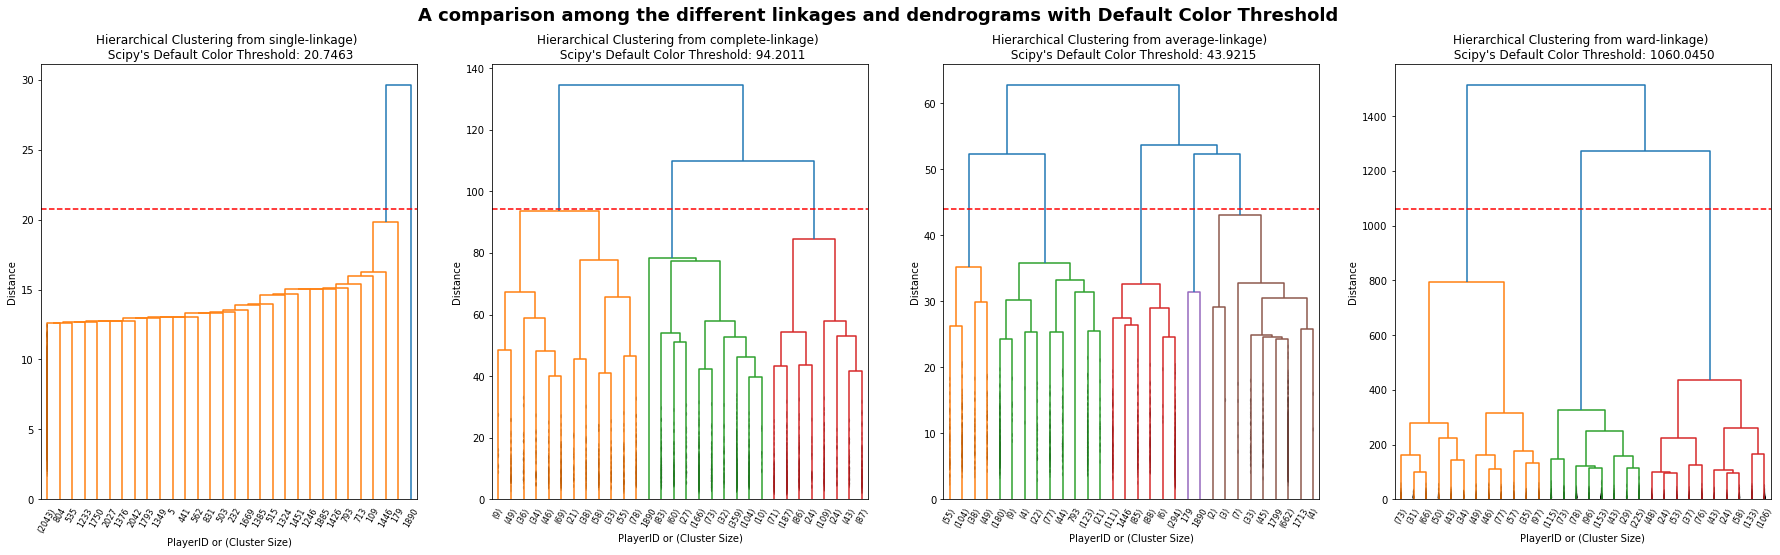

In [18]:
hierarchical_models = []

f, axs = plt.subplots(ncols=4, figsize=(31,8))

for i in range(len(methods)):
    model = AgglomerativeClustering(distance_threshold=0, n_clusters=None, affinity='euclidean', linkage=methods[i]).fit(data) 
    plot_dendrogram(model, truncate_mode='lastp', p=30, leaf_rotation=60, leaf_font_size = 8, show_contracted=True, ax=axs[i])
    hierarchical_models.append(model)

    axs[i].set_title('Hierarchical Clustering from ' + methods[i] + '-linkage) \n Scipy\'s Default Color Threshold: ' + '{:2.4f}'.format(defaults_color_thresholds[i]))
    axs[i].set_xlabel('PlayerID or (Cluster Size)')
    axs[i].set_ylabel('Distance')
    axs[i].axhline(defaults_color_thresholds[i], ls='--', color='r')

plt.suptitle(('A comparison among the different linkages and dendrograms with Default Color Threshold'),
             fontsize=18, fontweight='bold')
plt.show()

## Identifying the best cut

We define a function to identify the height of the optimal cut within a dendrogram. It works by iteratively cutting the tree at an height increased at each step. Each cut returns the given number of clusters identified by the structure under the cut and, by calculating the value for the number of clusters suggested by the greater number of cuts, we can identify the longest uninterrupted vertical segment of the dendrogram.

The function takes in input:

the linkage-method to utilize in order to compute the proximity among the nodes
the step to utilize to increase the height of the cuts at each iteration and
the data for which we want to perform the clustering.

In [19]:
def get_best_cut(linkage, step, norm_dataframe):
    store_n_clusters = []
    store_distances = []

    n_clusters = 0
    i = 0

    while n_clusters != 1:
        distance_threshold = i*step
        model = AgglomerativeClustering(distance_threshold=distance_threshold, n_clusters=None, affinity='euclidean', linkage=linkage).fit(norm_dataframe)
        i = i + 1

        n_clusters = model.n_clusters_
        store_distances.append(distance_threshold)
        store_n_clusters.append(n_clusters)

    df = pd.DataFrame()

    df['distance_thresholds'] = store_distances
    df['n_clusters'] = store_n_clusters
    
    df_n_clusters_groups = df.groupby('n_clusters').size()
    
    n_for_opt_cut = df_n_clusters_groups.agg(['idxmax'])[0]
    distance = df[df.n_clusters == n_for_opt_cut].distance_thresholds.min()
    
    print('Performed analysis for ' + linkage + '-linkage: reached n_clusters = 1 in ' + str(i) + ' steps')
    #print('OPT: Dist = ' + str(distance) + ', n_clusters = ' + str(n_for_opt_cut))     
    
    return n_for_opt_cut, distance

We search for the best cut within each of the four dendrograms.

In [20]:
#steps = [0.001, 0.01, 0.01, 0.1]
steps = [ 1,3,1,20]
opt_n_clusters = []
heights = []

for i in range(len(methods)):
    n_for_opt_cut, height = get_best_cut(methods[i], steps[i], data)
    opt_n_clusters.append(n_for_opt_cut)
    heights.append(height)
    
hierarchical_distances = pd.DataFrame()
hierarchical_distances['method'] = methods
hierarchical_distances['n_clusters_for_best_cut'] = opt_n_clusters
hierarchical_distances['height'] = heights
hierarchical_distances.set_index(['method'], inplace=True)

hierarchical_distances

Performed analysis for single-linkage: reached n_clusters = 1 in 31 steps
Performed analysis for complete-linkage: reached n_clusters = 1 in 46 steps
Performed analysis for average-linkage: reached n_clusters = 1 in 64 steps
Performed analysis for ward-linkage: reached n_clusters = 1 in 77 steps


,n_clusters_for_best_cut,height
method,,
single,2,20
complete,2,111
average,2,54
ward,3,800


We plot the dendrograms again, this time highlighting the best cut identified above.

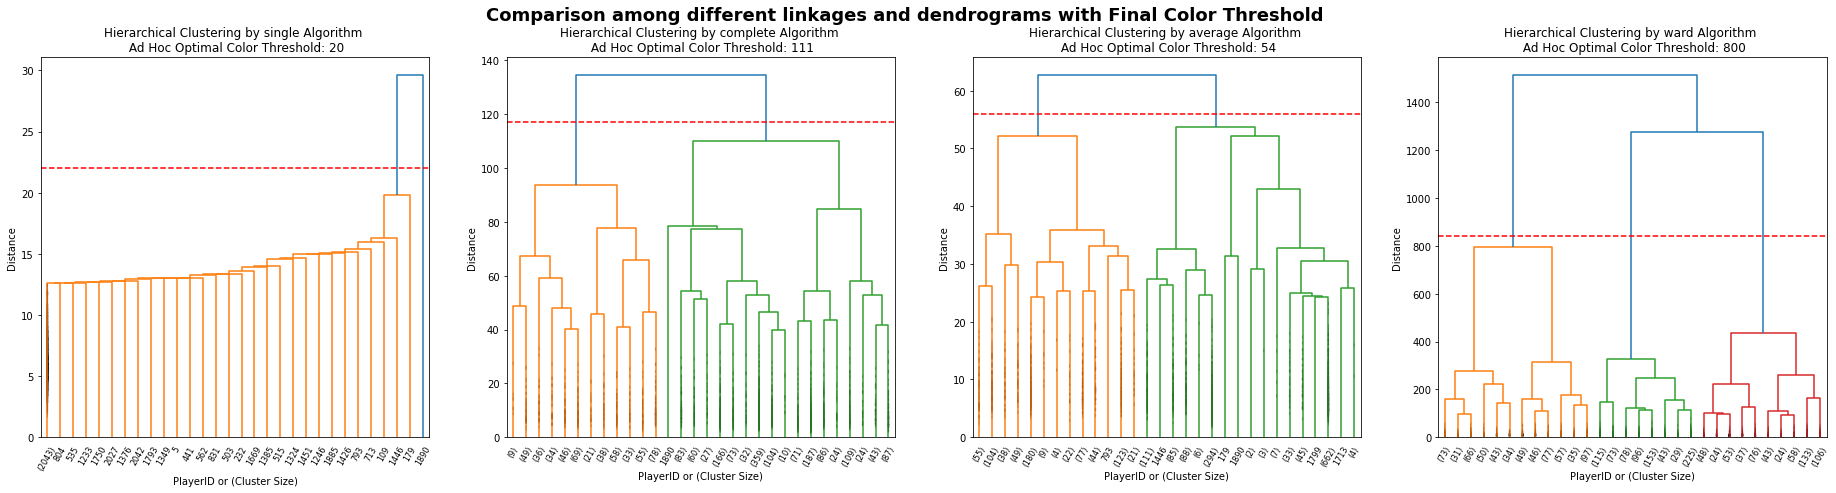

In [21]:
# plot dendrograms
hierarchical_models = []

f, axs = plt.subplots(ncols=4, figsize=(32,7))

for i in range(len(methods)):
    color_threshold = hierarchical_distances.loc[methods[i]].height
    model = AgglomerativeClustering(distance_threshold=0, n_clusters=None, affinity='euclidean', linkage=methods[i]).fit(data) 
    plot_dendrogram(model, truncate_mode='lastp', p=30, leaf_rotation=60, leaf_font_size = 8, show_contracted=True, ax=axs[i], color_threshold=color_threshold)
    hierarchical_models.append(model)
    
    axs[i].set_title('Hierarchical Clustering by ' + methods[i] + ' Algorithm \n Ad Hoc Optimal Color Threshold: ' + str(color_threshold))
    axs[i].set_xlabel('PlayerID or (Cluster Size)')
    axs[i].set_ylabel('Distance')
    axs[i].axhline(color_threshold + steps[i]*2, ls='--', color='r')

plt.suptitle(('Comparison among different linkages and dendrograms with Final Color Threshold'),
             fontsize=18, fontweight='bold')
plt.show()

We compute and store the labels associated with each cut.

In [22]:
cs_clusters = pd.DataFrame()

In [23]:
for i in range(len(methods)):
    opt_n_clusters = int(hierarchical_distances.loc[methods[i]].n_clusters_for_best_cut)
    temp = AgglomerativeClustering(n_clusters=opt_n_clusters, affinity='euclidean', linkage=methods[i])
    labels=temp.fit_predict(data)
    cs_clusters[methods[i]] = labels
    print(methods[i] , labels)

cs_clusters[['single', 'complete', 'average', 'ward']]

single [0 0 0 ... 0 0 0]
complete [0 0 0 ... 0 0 0]
average [0 0 0 ... 0 0 0]
ward [2 1 2 ... 1 2 1]


,single,complete,average,ward
0,0,0,0,2
1,0,0,0,1
2,0,0,0,2
3,0,0,0,1
4,0,0,0,1
...,...,...,...,...
2067,0,0,1,0
2068,0,0,0,1
2069,0,0,0,1
2070,0,0,0,2


We compare the four clusterings by visualizing the distribution of the points among their clusters.

In [24]:
X=data

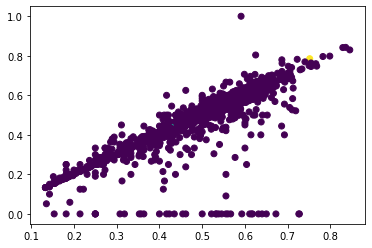

In [25]:
cluster = AgglomerativeClustering(n_clusters=opt_n_clusters, affinity='euclidean', linkage='single')
cluster.fit_predict(X)

plt.scatter(X[:,0],X[:,1], c=cluster.labels_)

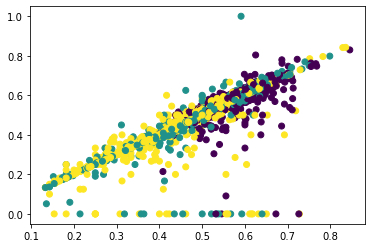

In [26]:
cluster = AgglomerativeClustering(n_clusters=opt_n_clusters, affinity='euclidean', linkage='complete')
cluster.fit_predict(X)

plt.scatter(X[:,0],X[:,1], c=cluster.labels_)

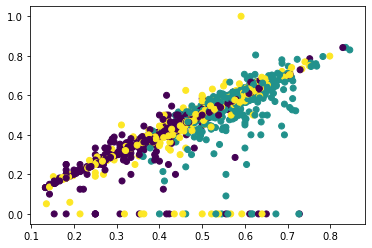

In [27]:
cluster = AgglomerativeClustering(n_clusters=opt_n_clusters, affinity='euclidean', linkage='average')
cluster.fit_predict(X)

plt.scatter(X[:,0],X[:,1], c=cluster.labels_)

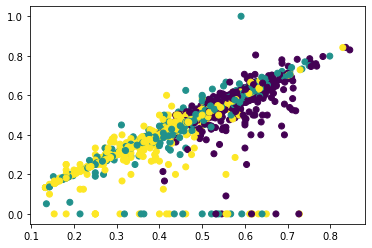

In [28]:
cluster = AgglomerativeClustering(n_clusters=opt_n_clusters, affinity='euclidean', linkage='ward')
cluster.fit_predict(X)

plt.scatter(X[:,0],X[:,1], c=cluster.labels_)

In [29]:
def comparison(a,b):
    f, axs = plt.subplots(nrows=1, ncols=4, figsize=(32,8))
    for i in range(len(methods)):
        labels = cs_clusters[methods[i]]
        opt_n_clusters = int(hierarchical_distances.loc[methods[i]].n_clusters_for_best_cut)
        scatter = axs[i].scatter(df[a], df[b], c=labels, s=20, cmap='cividis')
        axs[i].set_title('Scatter( '+a+', '+b+' ) via ' + methods[i] + '-linkage, n_clusters = ' + str(opt_n_clusters), fontdict={'fontsize': 'large'})
        axs[i].set_xlabel(a, fontdict={'fontsize': 'large'})
        axs[i].set_ylabel(b, fontdict={'fontsize': 'large'})

        # produce a legend with the unique colors from the scatter
        dbs_population = np.unique(labels, return_counts=True)

        legend1 = axs[i].legend(*scatter.legend_elements(), #legend_elements creates legend handles and labels for a PathCollection.
                            loc="lower center", title="Labels")

        axs[i].add_artist(legend1)

        # produce a legend 
        secondlegend = []
        classes = np.unique(labels).shape[0]

        for j in range(classes):
            secondlegend.append("{} has {} points".format(j, dbs_population[1][j]))
        handles = scatter.legend_elements()[0]
        labels_2 = secondlegend
        legend2 = axs[i].legend(handles, labels_2, loc="lower right", title="Population")

    plt.suptitle(('A comparison of clusterings from different algorithms'),
                 fontsize=24, fontweight='bold')

    plt.show()

## perc_v_ace-perc_v_1stwon

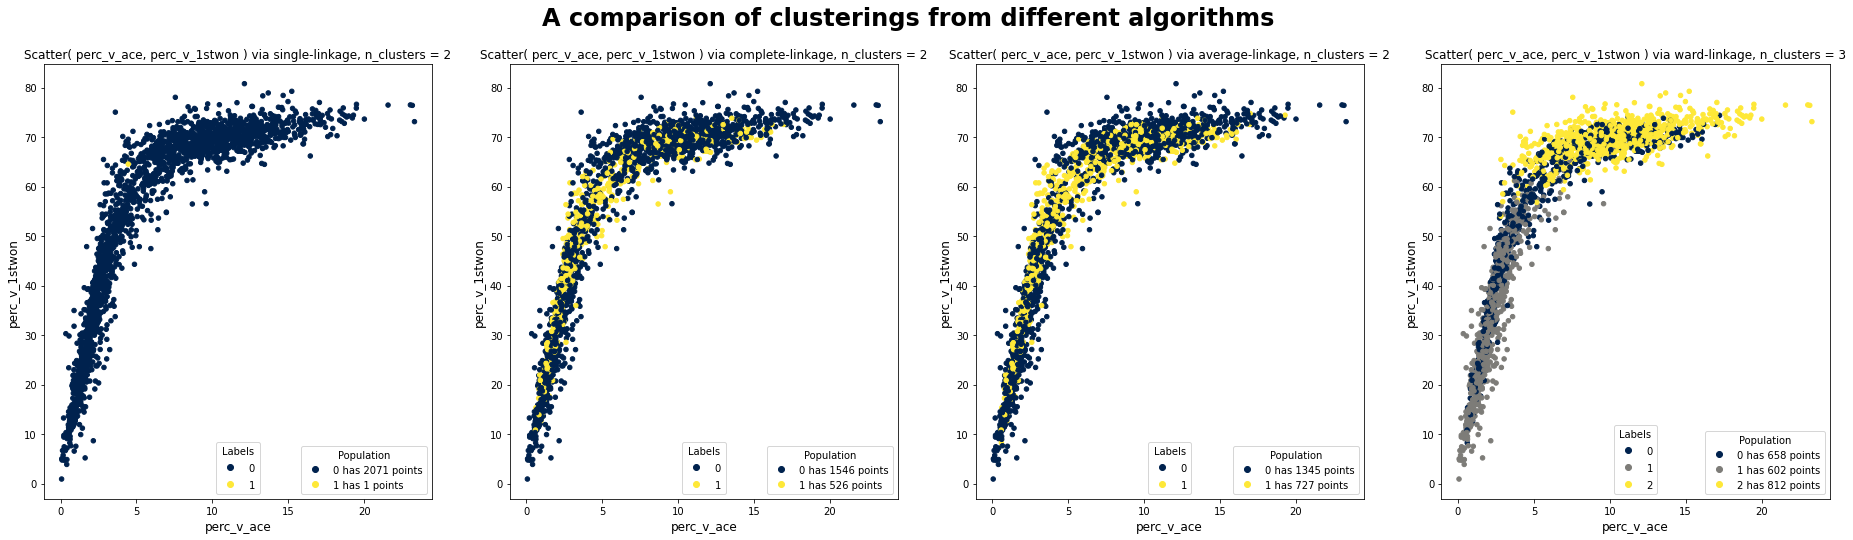

In [30]:
a, b = 'perc_v_ace', 'perc_v_1stwon'
comparison(a,b)


## perc_v_ace-perc_v_1stwon

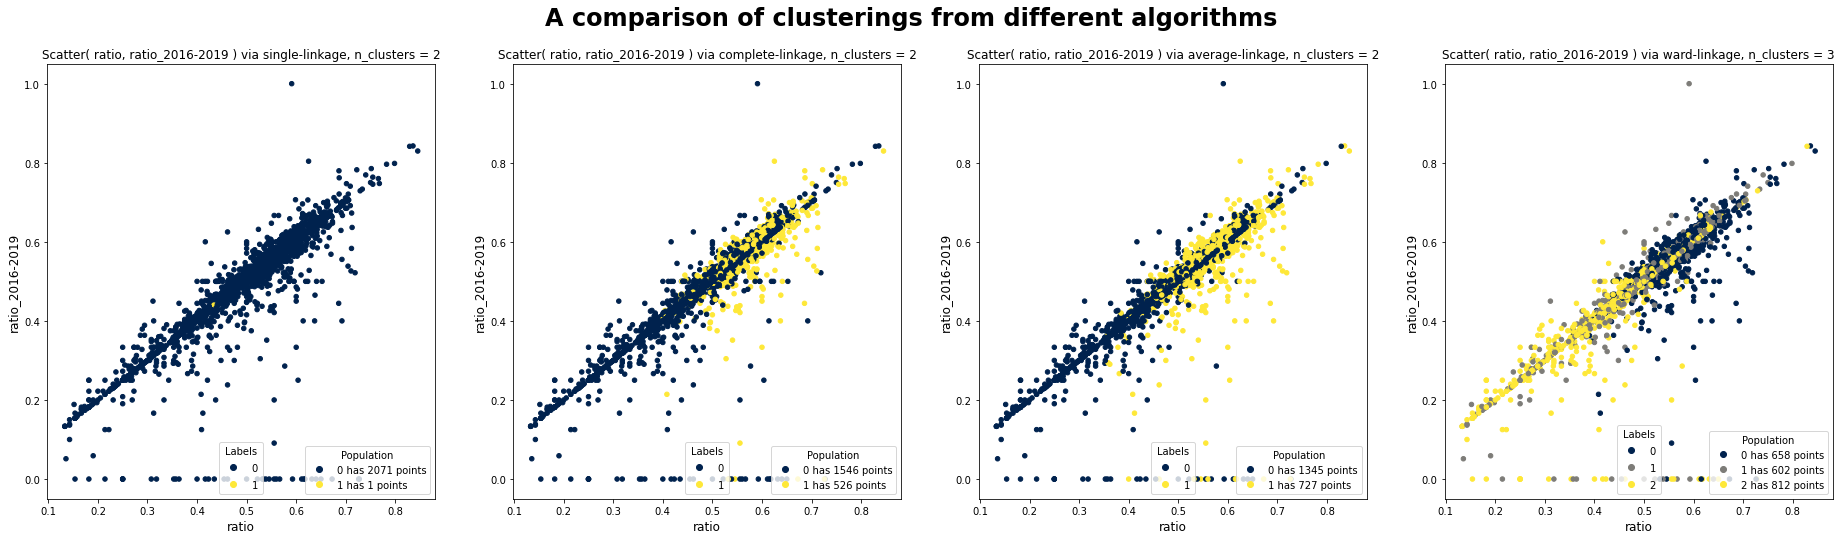

In [31]:
a, b = 'ratio', 'ratio_2016-2019'
comparison(a,b)

## 'num_matches_2020-2021', 'ratio_2020-2021'

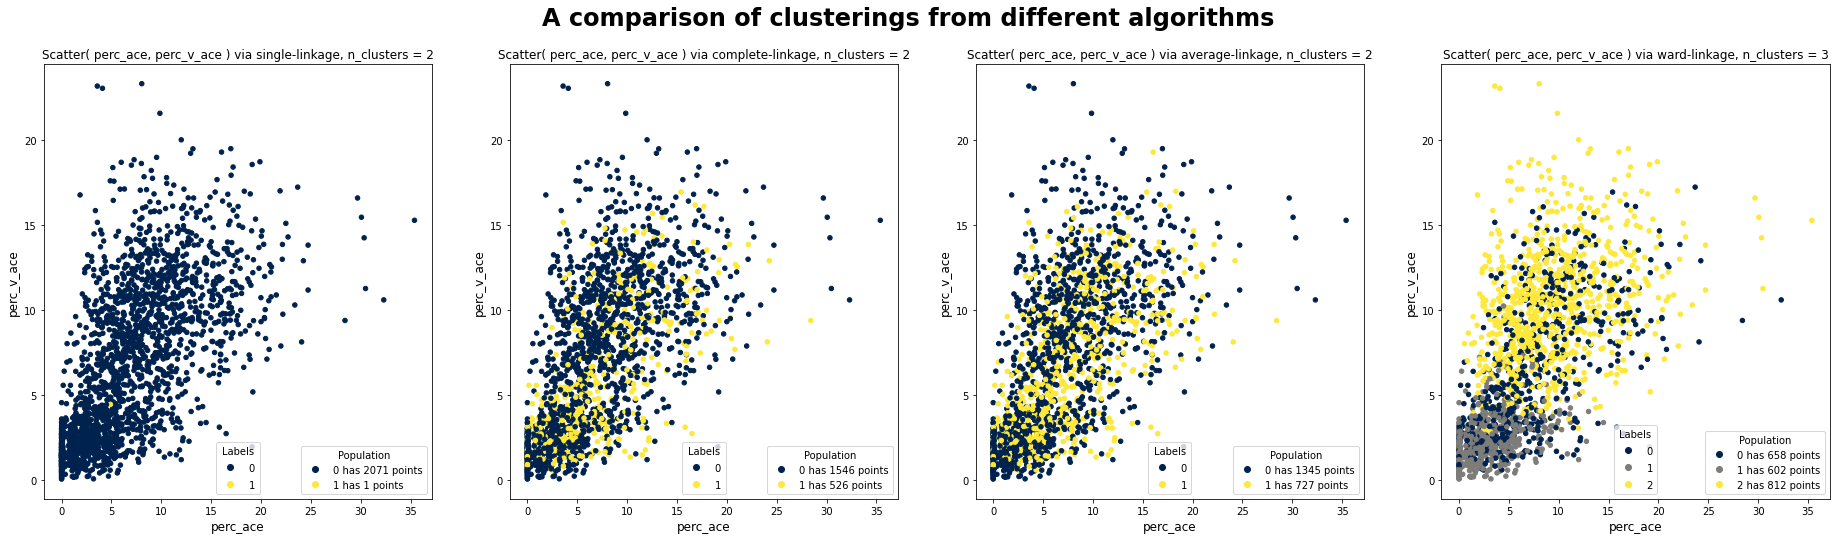

In [32]:
a, b = 'perc_ace', 'perc_v_ace'
comparison(a,b)

## Evaluation
Evaluation via Internal Metrics

In [33]:
metrics_H=pd.DataFrame() # we create a dataframe to contain the results of the evaluation
    
sep=[]
sil=[]
cal_har=[]
cophenetic_coefficients = []

for method in methods:
    sep.append(davies_bouldin_score(data, cs_clusters[method]))
    sil.append(silhouette_score(data, cs_clusters[method]))
    cal_har.append(calinski_harabasz_score(data, cs_clusters[method]))
    Z = linkage(data, method)
    cophenetic_coefficients = np.append(cophenetic_coefficients, np.corrcoef(pdist(data), cophenet(Z))[0][1])
    
#internal metric
metrics_H['Methods'] = methods
metrics_H['Davies_Bouldini'] = sep
metrics_H['Silhouette'] = sil
metrics_H['Calinski_Harabasz'] = cal_har

#esternal metric
metrics_H['cophenetic_corr'] = cophenetic_coefficients

#set index to methods
metrics_H.set_index(['Methods'], inplace=True)
metrics_H

,Davies_Bouldini,Silhouette,Calinski_Harabasz,cophenetic_corr
Methods,,,,
single,0.526801,0.326946,3.279467,0.337759
complete,1.156685,0.352152,1021.559285,0.728043
average,1.177854,0.370526,1237.360542,0.743514
ward,0.836261,0.433216,1843.523027,0.738405


In [34]:
# from the hierarchical clustering defined by the given linkage matrix and threshold return the cluster topology
def count_cluster_elements(data, threshold, criterion='distance'):
    count = {}
    clusters = fcluster(data, threshold, criterion)
    for c in clusters:
        count[c] = count[c]+1 if c in count else 1
    return count, clusters

In [35]:
data_dist = pdist(data, metric='euclidean')
data_link = linkage(data_dist, method='complete', metric='euclidean')
count, clusters = count_cluster_elements(data_link, 94.2011)
score = silhouette_score(data, clusters)
print("Clusters:", len(count.keys()), end=" - ")
print(list(reversed(sorted(count.values()))))
print(f"Silhouette score: {score}")

Clusters: 3 - [915, 631, 526]
Silhouette score: 0.3995198627466953


In [36]:
data_dist = pdist(data, metric='euclidean')
data_link = linkage(data_dist, method='single', metric='euclidean')
count, clusters = count_cluster_elements(data_link, 25.7)
score = silhouette_score(data, clusters)
print("Clusters:", len(count.keys()), end=" - ")
print(list(reversed(sorted(count.values()))))
print(f"Silhouette score: {score}")

Clusters: 2 - [2071, 1]
Silhouette score: 0.32694588465837804


In [37]:
data_dist = pdist(data, metric='euclidean')
data_link = linkage(data_dist, method='average', metric='euclidean')
count, clusters = count_cluster_elements(data_link, 43.92)
score = silhouette_score(data, clusters)
print("Clusters:", len(count.keys()), end=" - ")
print(list(reversed(sorted(count.values()))))
print(f"Silhouette score: {score}")

Clusters: 5 - [758, 585, 481, 246, 2]
Silhouette score: 0.43013640286380894


In [42]:
data_dist = pdist(data, metric='euclidean')
data_link = linkage(data_dist, method='ward', metric='euclidean')
count, clusters = count_cluster_elements(data_link, 600)
score = silhouette_score(data, clusters)
print("Clusters:", len(count.keys()), end=" - ")
print(list(reversed(sorted(count.values()))))
print(f"Silhouette score: {score}")

Clusters: 4 - [812, 602, 361, 297]
Silhouette score: 0.4484399769850509
